In [1]:
%load_ext autoreload
%autoreload 2

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
from pearce.emulator import OriginalRecipe, ExtraCrispy
from pearce.emulator import parameter, DEFAULT_PARAMS as PARAMS

In [3]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from itertools import cycle
colors = cycle(sns.color_palette())

In [4]:
#training_dir = '/u/ki/swmclau2/des/PearceLHC_wp_rp'
training_dir = ['/u/ki/swmclau2/des/PearceLHC_wp_rp','/u/ki/swmclau2/des/PearceLHC_wp_rp_dense',
                 '/u/ki/swmclau2/des/PearceFHC_wp_rp/']
fiducial_params = {'logM0': 12.20, 'logM1': 13.7, 'alpha': 1.02,
                      'logMmin': 12.1, 'f_c': 0.19, 'sigma_logM': 0.46}
rbins = np.array([  0.06309573,   0.12437607,   0.24517359,   0.34422476, 0.48329302, 0.67854546,\
           0.9526807 , 1.33756775,1.8779508 ,   2.6366509 ,   3.70186906,   5.19743987, 7.29722764, \
           10.24533859,  14.38449888,  20.1958975 , 28.35512583,  39.81071706] )
rpoints = (rbins[1:]+rbins[:-1])/2

In [5]:
y_param = 'logMmin'
emulation_point = [('f_c', 0.233), ('logM0', 12.0), ('sigma_logM', 0.533), 
                   ('alpha', 1.083),('logM1', 13.5), ('logMmin', 12.233)]
em_params = dict(emulation_point)
del em_params[y_param]

In [6]:
y_param_idx = -1
for idx, p in enumerate(PARAMS):
    if p.name==y_param:
        y_param_idx = idx
        break
        
y_vals = np.linspace(PARAMS[y_param_idx].low, PARAMS[y_param_idx].high, 4)
em_params[y_param] = y_vals

In [7]:
print em_params[y_param]

[ 11.7         11.96666667  12.23333333  12.5       ]


In [8]:
print len(em_params)

6


In [9]:
hyperparams = {'n_estimators': int(1e3),
              'max_depth': 5}

In [10]:
or_params = PARAMS[:]
or_params.append(parameter('r', 0, 1)) #95% sure bounds aren't used for r
emu1 = OriginalRecipe(training_dir,method = 'gbdt',hyperparams=hyperparams, params=or_params)
#emu1 = OriginalRecipe(training_dir,method = 'gp', params=or_params)

In [11]:
emu1.goodness_of_fit('/u/ki/swmclau2/des/PearceLHC_wp_rp_dense2').mean()

0.99146342300422741

In [12]:
rpoints = np.logspace(np.log10(rbins[1]), np.log10(rbins[-2]), 200)
log_xi_pred = emu1.emulate_wrt_r(em_params, rpoints)
log_xi_pred = log_xi_pred.reshape((-1, len(rpoints)))
log_xi_err = np.zeros_like(log_xi_pred)

In [13]:
log_xi_cov = emu1.estimate_uncertainty('/u/ki/swmclau2/des/PearceLHC_wp_rp_dense2')
log_xi_err = np.sqrt(np.diag(log_xi_cov))

In [14]:
truth_dir = '/u/ki/swmclau2/des/PearceFHC_wp_rp/'
plot_r, plot_xi, plot_xi_err = emu1.get_plot_data(em_params,truth_dir, independent_variable=None)
plot_r = plot_r.reshape((-1, len(rbins)-1))
plot_xi = plot_xi.reshape((-1, len(rbins)-1))
plot_xi_err = plot_xi_err.reshape((-1, len(rbins)-1))

In [15]:
plot_xi.shape, plot_r.shape, plot_xi_err.shape

((4, 17), (4, 17), (4, 17))

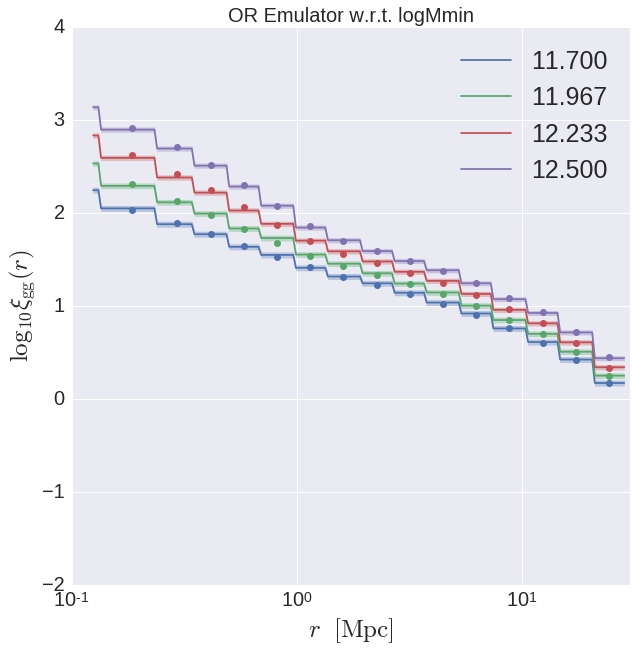

In [16]:
fig = plt.figure(figsize = (10, 10))
for label, lxp, lxe,pr, px, err,c in zip(y_vals, log_xi_pred, log_xi_err ,plot_r, plot_xi,plot_xi_err,colors):

    plt.plot(rpoints, lxp,label = '%.3f'%label, color = c )

    plt.fill_between(rpoints,lxp+lxe,
                     lxp-lxe, color = c, alpha = 0.3)

    plt.errorbar(10**pr, px,err, color =c,fmt = 'o')

plt.xlim(xmin = 0.1, xmax = 30)    
plt.ylim(ymin = -2, ymax = 4)
plt.title("OR Emulator w.r.t. %s"%y_param, fontsize =20)
#plt.loglog()
plt.xscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$r $  $\rm{[Mpc]}$', fontsize=25)
plt.ylabel(r'$\log_{10}{\xi_{\rm gg}(r) }$', fontsize=25)
plt.legend(loc='best', fontsize=25)

In [17]:
emu2 = ExtraCrispy(training_dir,method = 'gbdt',hyperparams=hyperparams)#no r in params
#emu2 = ExtraCrispy(training_dir)

In [18]:
rpoints = np.logspace(np.log10(emu2.bin_centers[1]), np.log10(emu2.bin_centers[-2]), 17)

In [19]:
log_xi_pred = emu2.emulate_wrt_r(em_params,rpoints)
log_xi_pred = log_xi_pred.reshape((-1, len(rpoints)))
log_xi_err = np.zeros_like(log_xi_pred)

In [20]:
log_xi_cov = emu2.estimate_uncertainty('/u/ki/swmclau2/des/PearceLHC_wp_rp_dense2')
log_xi_err = np.sqrt(np.diag(log_xi_cov))

In [21]:
emu2.goodness_of_fit('/u/ki/swmclau2/des/PearceLHC_wp_rp_dense2').mean()

0.99141093242067502

In [22]:
print log_xi_pred[:,0]
print plot_xi[:,0]

[ 2.02219582  2.31309032  2.63809049  2.92078286]
[ 2.22834528  2.54148836  2.8554588   3.14435658]


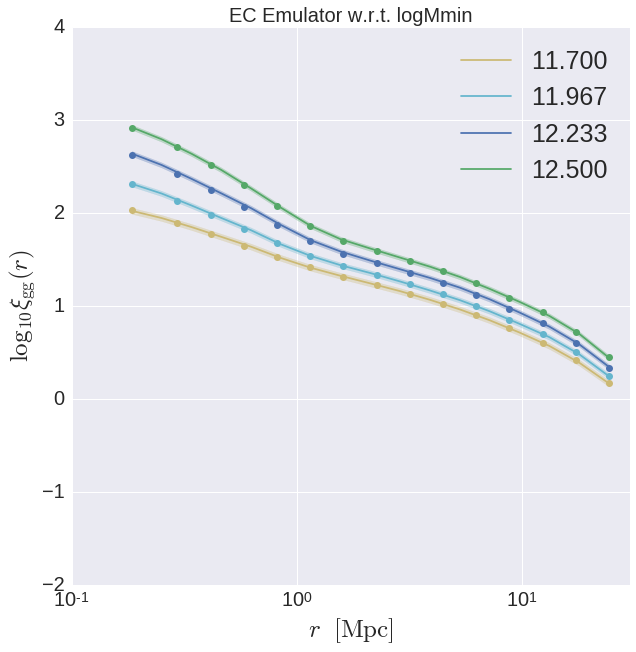

In [23]:
fig = plt.figure(figsize = (10, 10))
for label, lxp, lxe,pr, px, err,c in zip(y_vals, log_xi_pred, log_xi_err ,plot_r, plot_xi,plot_xi_err,colors):

    plt.plot(rpoints, lxp,label = '%.3f'%label, color = c )

    plt.fill_between(rpoints,lxp+lxe,
                     lxp-lxe, color = c, alpha = 0.3)

    plt.errorbar(10**pr, px,err, color =c,fmt = 'o')

plt.xlim(xmin = 0.1, xmax = 30)    
plt.ylim(ymin = -2, ymax = 4)
plt.title("EC Emulator w.r.t. %s"%y_param, fontsize =20)
#plt.loglog()
plt.xscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$r $  $\rm{[Mpc]}$', fontsize=25)
plt.ylabel(r'$\log_{10}{\xi_{\rm gg}(r) }$', fontsize=25)
plt.legend(loc='best', fontsize=25)

In [24]:
gbt_most_vals = emu1.goodness_of_fit('/u/ki/swmclau2/des/PearceLHC_wp_rp_dense2', statistic='rel').reshape((-1, len(emu1.bin_centers)))
gbt_most_err = np.abs(gbt_most_vals).mean(axis=0)
gbt_most_err_errs = np.abs(gbt_most_vals).std(axis=0)

In [25]:
gbt_most_vals[0,:]

array([ 0.00658884, -0.00225826, -0.00752031, -0.01677789,  0.00243305,
        0.0146872 ,  0.00599752, -0.00486732,  0.00688407,  0.0036558 ,
        0.00837282,  0.00066203,  0.004843  , -0.02368756, -0.01981487,
       -0.05325233,  0.19102723])

In [26]:
box = 'lhc'
gbt_vals = np.loadtxt('gbtr_%s.npy'%box)
gbt_err = np.abs(gbt_vals).mean(axis=0)
gbt_err_errs = np.abs(gbt_vals).std(axis=0)
gbt_dense_vals = np.loadtxt('gbtr_dense_%s.npy'%box)
gbt_dense_err = np.abs(gbt_dense_vals).mean(axis=0)
gbt_dense_err_errs = np.abs(gbt_dense_vals).std(axis=0)
svr_vals = np.loadtxt('svr_%s.npy'%box)
svr_err = np.abs(svr_vals).mean(axis=0)
svr_err_errs = np.abs(svr_vals).std(axis=0)
gp_vals = np.loadtxt('gp_%s.npy'%box)
gp_err = np.abs(gp_vals).mean(axis=0)
gp_err_errs = np.abs(gp_vals).std(axis=0)

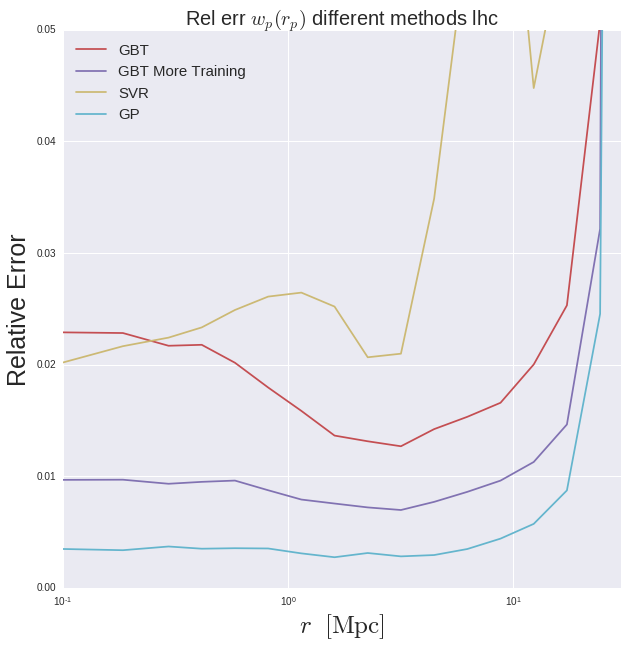

In [27]:
fig = plt.figure(figsize = (10, 10))
errs = (gbt_err,gbt_most_err, svr_err, gp_err)
err_errs = (gbt_err_errs,gbt_most_err_errs, svr_err_errs, gp_err_errs)
for label, err, ees,c in zip(('GBT','GBT More Training','SVR', 'GP'),errs, err_errs, colors ):
    plt.plot(emu1.bin_centers, err, label=label, color=c)
    #plt.fill_between(emu1.bin_centers, ees+err,err,color=c,alpha = 0.3)

plt.xlim(xmin = 0.1, xmax = 30)
plt.ylim(ymin = 0, ymax = 0.05)
plt.title(r"Rel err $w_p(r_p)$ different methods %s"%box, fontsize =20)
#plt.loglog()
plt.xscale('log')
plt.xlabel(r'$r $  $\rm{[Mpc]}$', fontsize=25)
plt.ylabel(r'Relative Error', fontsize = 25)
plt.legend(loc='best', fontsize = 15)